<a href="https://colab.research.google.com/github/ningjingzhiyuan507/AnalysisTool/blob/master/d2l.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 配置GPU版本pytorch

In [ ]:
# 不运行以下代码，总是在import d2l中出错
#!pip install timm==0.4.12
!pip install torch==1.8.1
!pip install torchvision==0.9.1

     |████████████████████████████████| 804.1 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.


     |████████████████████████████████| 17.4 MB 26.5 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111


In [1]:
!pip install d2l==0.17.3

     |████████████████████████████████| 82 kB 298 kB/s 
     |████████████████████████████████| 11.6 MB 44.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 9.9 MB 33.5 MB/s 
     |████████████████████████████████| 61 kB 6.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the p

In [2]:
!pip install matplotlib==3.0.0

     |████████████████████████████████| 12.8 MB 8.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
d2l 0.17.3 requires matplotlib==3.3.3, but you have matplotlib 3.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
# 测试GPU
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
torch.cuda.device_count()  # 仅有一个GPU

1

In [ ]:
X = torch.rand(2, 3, device='cuda:0')

In [ ]:
X

tensor([[0.5041, 0.4009, 0.8702],
        [0.5575, 0.4337, 0.0781]], device='cuda:0')

# LeNet-5

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [ ]:
batchSize = 256
trainIter, testIter = d2l.load_data_fashion_mnist(batch_size=batchSize)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def evaluateAccuracyGpu(net, dataIter, device=None):
  """使用GPU计算模型在数据集上的精度"""
  if isinstance(net, nn.Module):
    net.eval()  # 设置为评估模式
    if not device:
      device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
      for X, y in dataIter:
        if isinstance(X, list):
          X = [x.to(device) for x in X]
        else:
          X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def train_ch6(net, trainIter, testIter, numEpochs, lr, device):
  """用GPU训练模型"""
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)  # 使用Xavier随机初始化模型参数
  net.apply(init_weights)
  print("training on", device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, numEpochs], legend=['train loss', 'train acc', 'test acc'])
  timer, numBatches = d2l.Timer(), len(trainIter)
  for epoch in range(numEpochs):
    # 训练损失之和，训练准确率之和，样本数
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(trainIter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      yHat = net(X)
      l = loss(yHat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(yHat, y), X.shape[0])
      timer.stop()
      trainL = metric[0] / metric[2]
      trainAcc = metric[1] / metric[2]
      if (i+1) % (numBatches // 5) == 0 or i == numBatches - 1:
        animator.add(epoch + (i+1) / numBatches, (trainL, trainAcc, None))
    testAcc = evaluateAccuracyGpu(net, testIter)
    animator.add(epoch + 1, (None, None, testIter))
  print(f'loss {trainL: .3f}, train acc {trainAcc:.3f},'
        f'test acc {testAcc:.3f}')
  print(f'{metric[2] * numEpochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

TypeError: ignored

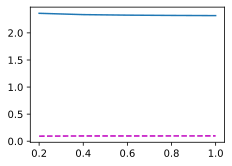

In [ ]:
lr, numEpochs = 0.9, 10
train_ch6(net, trainIter, testIter, numEpochs, lr, 'cuda')

loss 0.494, train acc 0.812, test acc 0.783
24635.0 examples/sec on cuda


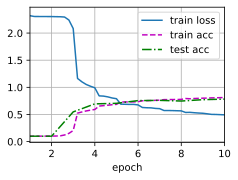

In [ ]:
d2l.train_ch6(net, trainIter, testIter, numEpochs, lr, 'cuda')

# 现代卷积神经网络

## AlexNet

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
net = nn.Sequential(
    # 这里我们使用一个11*11的更大窗口来捕捉对象（image图像比LeNet使用的图像都要大10倍以上）
    # 同时，步幅为4以减少输出的高度和宽度
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用padding为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，pooling不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10
    nn.Linear(4096, 10)
)

In [ ]:
batchSize = 128
trainIter, testIter = d2l.load_data_fashion_mnist(batchSize, resize=224)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss 0.328, train acc 0.880, test acc 0.883
1411.3 examples/sec on cuda


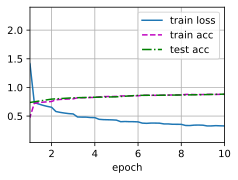

In [ ]:
lr, numEpochs = 0.01, 10
d2l.train_ch6(net, trainIter, testIter, numEpochs, lr, 'cuda')

## VGG

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def vgg_block(num_convs, in_channels, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    )
    layers.append(nn.ReLU())
    in_channels = out_channels
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
  conv_blks = []
  in_channels = 1
  # 卷积层部分
  for (num_convs, out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
    in_channels = out_channels

  return nn.Sequential(
      *conv_blks, nn.Flatten(),
      # 全连接层部分
      nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 10)
  )

In [ ]:
net = vgg(conv_arch)

In [ ]:
# 测试
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
  X = blk(X)
  print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# 训练模型
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cuda')

KeyboardInterrupt: ignored

ImportError: ignored

<Figure size 252x180 with 1 Axes>

## NiN

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
  )

In [ ]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数量是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    # 将四维的输出转化成二维的输出，其形状为（批量大小，10）
    nn.Flatten()
)

In [ ]:
# 测试
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.792, train acc 0.734, test acc 0.754
1046.7 examples/sec on cuda


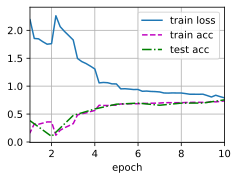

In [ ]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cuda')

## GoogLeNet

In [ ]:
from torch.nn import functional as F

In [ ]:
class Inception(nn.Module):
  # c1-c4是每条路径的输出通道数
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
      super(Inception, self).__init__(**kwargs)
      # 线路1，单1×1卷积层
      self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
      # 线路2，1*1卷积层后接3*3卷积层
      self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
      self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
      # 线路3，1*1卷积层后接5*5卷积层
      self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
      self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
      # 线路4，3*3最大汇聚层后接1*1卷积层
      self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
      self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

  def forward(self, x):
      p1 = F.relu(self.p1_1(x))
      p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
      p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
      p4 = F.relu(self.p4_2(self.p4_1(x)))
      # 在通道维度上联结输出
      return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [ ]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [ ]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [ ]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [ ]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
  )

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
# 测试
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, "output shape:\t", X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.258, train acc 0.902, test acc 0.890
1355.9 examples/sec on cuda


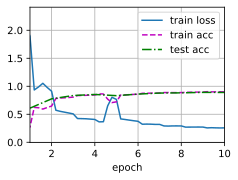

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cuda')

## 批量规范化

### 从零实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
  if not torch.is_grad_enabled():
    # 如果是在预测模式下，直接使用传入的移动平均得到的均值和方差
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2, 4)
    if len(X.shape) == 2:
      # 使用全连接层的情况，计算特征维上的均值和方差
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差
      # 这里我们需要保持X的shape，以便于后面做广播运算
      mean = X.mean(dim=(0, 2, 3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
    # 训练模式下，用当前的均值和方差做标准化
    X_hat = (X - mean) / torch.sqrt(var + eps)
    # 更新移动平均的均值和方差
    moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var = momentum * moving_var + (1.0 - momentum) * var
  Y = gamma * X_hat + beta  # 缩放和移位
  return Y, moving_mean.data, moving_var.data

In [ ]:
class BatchNorm(nn.Module):
  # num_features: 完全连接层的输出数量或卷积层的输出通道数
  # num_dims: 2表示完全连接层，4表示卷积层
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    # 非模型参数的变量初始化成0和1
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)

  def forward(self, X):
    # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    # 保存更新过的moving_mean和moving_var
    Y, self.moving_mean, self.moving_var = batch_norm(
        X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9
    )
    return Y

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.270, train acc 0.901, test acc 0.844
9078.8 examples/sec on cuda


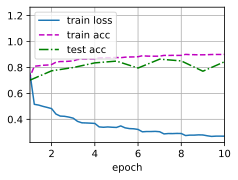

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cuda')

In [ ]:
# 查看第一个批量规范化层训练出的拉伸参数gamma和偏移参数beta
net[1].gamma.reshape((-1, )), net[1].beta.reshape((-1,))

(tensor([2.8275, 4.0946, 2.8114, 0.2814, 1.4243, 3.3104], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 0.2636, -2.4335, -2.9745, -0.1787,  1.3267,  2.7043], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

### 简明实现

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.260, train acc 0.904, test acc 0.878
16382.1 examples/sec on cuda


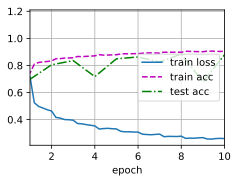

In [ ]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cuda')

# 计算机视觉

## 图像增广

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
# 加载CIFAR-10数据集，共50W个图片
all_images = torchvision.datasets.CIFAR10(train=True, root='../data', download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f34b5a20d10>,
      dtype=object)

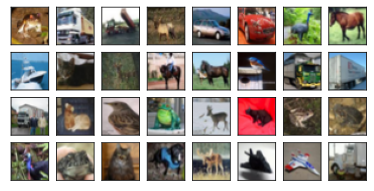

In [ ]:
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [ ]:
train_augs = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
    ]
)
test_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [ ]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root='../data', train=is_train, transform=augs, download=True
    )
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, num_workers=d2l.get_dataloader_workers()
    )
    return dataloader

In [ ]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多CPU进行小批量训练"""
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [ ]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(
        xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc']
    )
    # net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    net = net.to(devices[0])  # 当cpu和gpu同时存在时要明确指明计算位置
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
        
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    
    print(f'loss {metric[0] / metric[2]:.3f}, train acc {metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')

In [ ]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr = 0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.177, train acc 0.938, test acc 0.785
352.7 examples/sec on [device(type='cuda', index=0)]


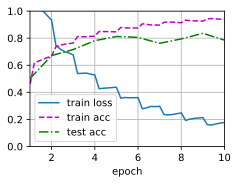

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

## 微调(迁移学习)

In [ ]:
import os

In [ ]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

In [ ]:
# 读取图像文件
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f34b0541ad0>,
      dtype=object)

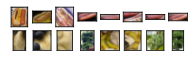

In [ ]:
# 正负样本展示
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs, 2, 8, scale=0.4)

In [ ]:
# 通道标准化
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# 图像缩放和增广
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize
])

In [ ]:
# 以ResNet-18为源模型
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Parameter containing:
tensor([[ 0.0922, -0.0671, -0.0683,  ...,  0.0695,  0.0001,  0.0108],
        [ 0.0180,  0.0694,  0.0484,  ..., -0.1023, -0.0687, -0.0311]],
       requires_grad=True)

In [ ]:
# 微调模型
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
  train_iter = torch.utils.data.DataLoader(
      torchvision.datasets.ImageFolder(
          os.path.join(data_dir, 'train'), transform=train_augs
      ),
      batch_size=batch_size, shuffle=True
  )
  test_iter = torch.utils.data.DataLoader(
      torchvision.datasets.ImageFolder(
          os.path.join(data_dir, 'test'), transform=test_augs
      ),
      batch_size=batch_size
  )
  devices = d2l.try_all_gpus()
  loss = nn.CrossEntropyLoss(reduction='none')
  if param_group:
    params_lx = [param for name, param in net.named_parameters() if name not in ['fc.weight', 'fc.bias']]
    trainer = torch.optim.SGD([
        {'params': params_lx},
        {'params': net.fc.parameters(), 'lr': learning_rate * 10}],
        lr=learning_rate, weight_decay=0.001
      )
  else:
    trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
  
  d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.146, train acc 0.944, test acc 0.939
178.2 examples/sec on [device(type='cuda', index=0)]


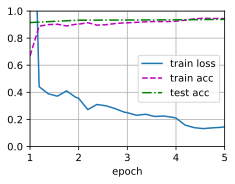

In [ ]:
train_fine_tuning(finetune_net, 5e-5)

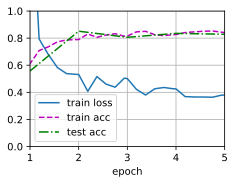

In [ ]:
# 重新训练模型
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

## 单发多框检测

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
# 类别预测层
def cls_predictor(num_inputs, num_anchors, num_classes):
  return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)

# 边界框预测层
def bbox_predictor(num_inputs, num_anchors):
  return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [ ]:
# 连接多尺度的预测
def forward(x, block):
  return block(x)

In [ ]:
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))

In [ ]:
def flatten_pred(pred):
  return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
  return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [ ]:
# 高宽减半块
def down_sample_blk(in_channels, out_channels):
  blk = []
  for _ in range(2):
    blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    blk.append(nn.BatchNorm2d(out_channels))
    blk.append(nn.ReLU())
    in_channels = out_channels
  blk.append(nn.MaxPool2d(2))
  return nn.Sequential(*blk)

In [ ]:
# 基本网络块
def base_net():
  blk = []
  num_filters = [3, 16, 32, 64]
  for i in range(len(num_filters) - 1):
    blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
  return nn.Sequential(*blk)

In [ ]:
forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [ ]:
# 完整模型
def get_blk(i):
  if i == 0:
    blk = base_net()
  elif i == 1:
    blk = down_sample_blk(64, 128)
  elif i == 4:
    blk = nn.AdaptiveMaxPool2d((1, 1))
  else:
    blk = down_sample_blk(128, 128)
  
  return blk

In [ ]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
  Y = blk(X)
  anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
  cls_preds = cls_predictor(Y)
  bbox_preds = bbox_predictor(Y)

  return (Y, anchors, cls_preds, bbox_preds)

In [ ]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [ ]:
class TinySSD(nn.Module):
  def __init__(self, num_classes, **kwargs):
    super(TinySSD, self).__init__(**kwargs)
    self.num_classes = num_classes
    idx_to_in_channels = [64, 128, 128, 128, 128]
    for i in range(5):
      setattr(self, f'blk_{i}', get_blk(i))
      setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
      setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))

  def forward(self, X):
    anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
    for i in range(5):
      X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
          X, getattr(self, f'blk_{i}'), sizes[i], ratios[i], 
          getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}')
      )
    anchors = torch.cat(anchors, dim=1)
    cls_preds = concat_preds(cls_preds)
    cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
    bbox_preds = concat_preds(bbox_preds)

    return anchors, cls_preds, bbox_preds

In [ ]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# 训练模型
## 读取数据集
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

read 1000 training examples
read 100 validation examples


In [ ]:
## 定义损失函数和评价函数
cls_loss = nn.CrossEntropyLoss(reduction="none")
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
  batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
  cls = cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
  bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)

  return cls + bbox

In [ ]:
def cls_eval(cls_preds, cls_labels):
  return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
  return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class err 3.24e-03, bbox mae 3.12e-03
3210.1 examples/sec on cuda:0


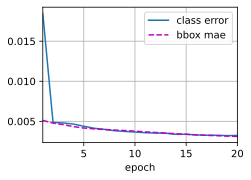

In [ ]:
## 训练模型
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
  metric = d2l.Accumulator(4)
  net.train()
  for features, target in train_iter:
    timer.start()
    trainer.zero_grad()
    X, Y = features.to(device), target.to(device)
    anchors, cls_preds, bbox_preds = net(X)
    bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
    l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
    l.mean().backward()
    trainer.step()
    metric.add(
        cls_eval(cls_preds, cls_labels), cls_labels.numel(), 
        bbox_eval(bbox_preds, bbox_labels, bbox_masks), bbox_labels.numel()
    )
  cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
  animator.add(epoch + 1, (cls_err, bbox_mae))

print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on {str(device)}')

In [ ]:
# 预测目标
X = torchvision.io.read_image('/data/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [ ]:
def predict(X):
  net.eval()
  anchors, cls_preds, bbox_preds = net(X.to(device))
  cls_preds = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
  output = d2l.multibox_detection(cls_preds, bbox_preds, anchors)
  idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
  return output[0, idx]

output = predict(X)

In [ ]:
def display(img, output, threshold):
  d2l.set_figsize((5, 5))
  fig = d2l.plt.imshow(img)
  for row in output:
    score = float(row[1])
    if score < threshold:
      continue
    h, w = img.shape[0:2]
    bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
    d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

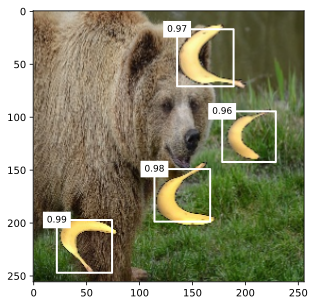

In [ ]:
display(img, output.cpu(), 0.9)

## 风格迁移

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

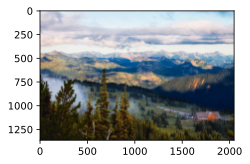

In [ ]:
# display内容和风格图像
d2l.set_figsize()
content_img = d2l.Image.open('/data/rainier.jpg')
d2l.plt.imshow(content_img)

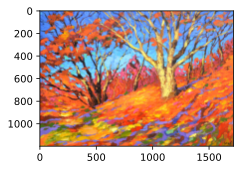

In [ ]:
style_img = d2l.Image.open('/data/autumn-oak.jpg')
d2l.plt.imshow(style_img)

In [ ]:
# 预处理和后处理
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
  transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
  ])

  return transforms(img).unsqueeze(0)

def postprocess(img):
  img = img[0].to(rgb_std.device)
  img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)

  return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [ ]:
# 抽取图像特征
pretrained_net = torchvision.models.vgg19(pretrained=True)
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])

def extract_features(X, content_layers, style_layers):
  contents = []
  styles = []
  for i in range(len(net)):
    X = net[i](X)
    if i in style_layers:
      styles.append(X)
    if i in content_layers:
      contents.append(X)
  
  return contents, styles

def get_contents(image_shape, device):
  content_X = preprocess(content_img, image_shape).to(device)
  contents_Y, _ = extract_features(content_X, content_layers, style_layers)

  return content_X, contents_Y

def get_styles(image_shape, device):
  style_X = preprocess(style_img, image_shape).to(device)
  _, styles_Y = extract_features(style_X, content_layers, style_layers)

  return style_X, styles_Y 

In [ ]:
# 定义损失函数
## 内容损失
def content_loss(Y_hat, Y):
  return torch.square(Y_hat - Y.detach()).mean()

## 风格损失
def gram(X):
  num_channels, n = X.shape[1], X.numel() // X.shape[1]
  X = X.reshape((num_channels, n))
  return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
  return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

## 全变分损失
def tv_loss(Y_hat):
  return 0.5 * (
      torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() + 
      torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean()
  )

## 损失函数
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
  contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
  styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
  tv_l = tv_loss(X) * tv_weight
  l = sum(10 * styles_l + contents_l + [tv_l])

  return contents_l, styles_l, tv_l, l

In [ ]:
# 初始化合成图像
class SynthesizedImage(nn.Module):
  def __init__(self, img_shape, **kwargs):
    super(SynthesizedImage, self).__init__(**kwargs)
    self.weight = nn.Parameter(torch.rand(*img_shape))
  
  def forward(self):
    return self.weight

def get_inits(X, device, lr, styles_Y):
  gen_img = SynthesizedImage(X.shape).to(device)
  gen_img.weight.data.copy_(X.data)
  trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
  styles_Y_gram = [gram(Y) for Y in styles_Y]

  return gen_img(), styles_Y_gram, trainer 

In [ ]:
# 训练模型
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
  X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
  animator = d2l.Animator(
      xlabel='epoch', ylabel='loss', xlim=[10, num_epochs], legend=['content', 'style', 'TV'],
      ncols = 2, figsize=(7, 2.5)
  )
  for epoch in range(num_epochs):
    trainer.zero_grad()
    contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
    content_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, content_Y, styles_Y_gram)
    l.backward()
    trainer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
      animator.axes[1].imshow(postprocess(X))
      animator.add(epoch + 1, [float(sum(content_l)), float(sum(styles_l)), float(tv_l)])
    
  return X

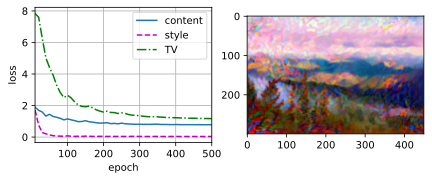

In [ ]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, content_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, content_Y, styles_Y, device, 0.3, 500, 50)

## kaggle比赛：图像分类(CIFAR-10)

In [ ]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
# 下载并整理数据集(1000训练样本10个类别)
d2l.DATA_HUB['cifar10_tiny'] = (
    d2l.DATA_URL + 'kaggle_cifar10_tiny.zip', 
    '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd'
)
data_dir = d2l.download_extract('cifar10_tiny')

def read_csv_labels(fname):
  with open(fname, 'r') as f:
    lines = f.readlines()[1:]
  tokens = [l.rstrip().split(',') for l in lines]
  return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))

In [ ]:
def copyfile(filename, target_dir):
  os.makedirs(target_dir, exist_ok=True)
  shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
  n = collections.Counter(labels.values()).most_common()[-1][1]
  n_valid_per_label = max(1, math.floor(n * valid_ratio))
  label_count = {}
  for train_file in os.listdir(os.path.join(data_dir, 'train')):
    label = labels[train_file.split('.')[0]]
    fname = os.path.join(data_dir, 'train', train_file)
    copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', 'label'))
    if label not in label_count or label_count[label] < n_valid_per_label:
      copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
      label_count[label] = label_count.get(label, 0) + 1
    else:
      copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
  
  return n_valid_per_label

def reorg_test(data_dir):
  for test_file in os.listdir(os.path.join(data_dir, 'test')):
    copyfile(os.path.join(data_dir, 'test', test_file), 
             os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

def reorg_cifar10_data(data_dir, valid_ratio):
  labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
  reorg_train_valid(data_dir, labels, valid_ratio)
  reorg_test(data_dir)

batch_size = 32
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [ ]:
# 图像增广
transform_train = torchvision.transforms.Compose([
  torchvision.transforms.Resize(40),
  torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])
transform_test = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [ ]:
# 读取数据
train_ds, train_valid_ds = [
  torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),
                                   transform=transform_train) for folder in ['train', 'train_valid']
]
valid_ds, test_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),
                                                      transform=transform_test) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [
  torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, 
                              drop_last=True) for dataset in (train_ds, train_valid_ds)]
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

In [ ]:
# 定义模型
def get_net():
  num_classes = 10
  net = d2l.resnet18(num_classes, 3)
  return net

loss = nn.CrossEntropyLoss(reduction='none')

In [ ]:
# 定义训练函数
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay):
  trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
  num_batches, timer = len(train_iter), d2l.Timer()
  legend = ['train loss', 'train acc']
  if valid_iter is not None:
    legend.append('valid acc')
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    net.train()
    metric = d2l.Accumulator(3)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = d2l.train_batch_ch13(net, features, labels,
      loss, trainer, devices)
      metric.add(l, acc, labels.shape[0])
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[2], None))
    if valid_iter is not None:
      valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
      animator.add(epoch + 1, (None, None, valid_acc))
    scheduler.step()
  measures = (f'train loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}')
  if valid_iter is not None:
    measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.667, train acc 0.763, valid acc 0.422
313.0 examples/sec on [device(type='cuda', index=0)]


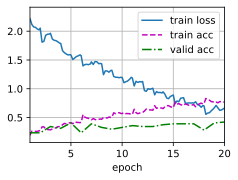

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

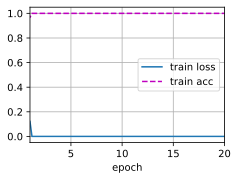

In [ ]:
# 预测
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

for X, _ in test_iter:
  y_hat = net(X.to(devices[0]))
  preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

## kaggle比赛：狗的品种识别

In [ ]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
# 下载数据集
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip', '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')
data_dir = d2l.download_extract('dog_tiny')

In [ ]:
# 整理数据集
def reorg_dog_data(data_dir, valid_ratio):
  labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
  d2l.reorg_train_valid(data_dir, labels, valid_ratio)
  d2l.reorg_test(data_dir)

batch_size = 32
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

In [ ]:
# 图像增广
transform_train = torchvision.transforms.Compose([
  torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)),
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = torchvision.transforms.Compose([
  torchvision.transforms.Resize(256),
  torchvision.transforms.CenterCrop(224),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# 读取数据集
train_ds, train_valid_ds = [
  torchvision.datasets.ImageFolder(
      os.path.join(data_dir, 'train_valid_test', folder), transform=transform_train
  ) for folder in ['train', 'train_valid']
]

valid_ds, test_ds = [
  torchvision.datasets.ImageFolder(
      os.path.join(data_dir, 'train_valid_test', folder), transform=transform_test
  ) for folder in ['valid', 'test']
]

train_iter, train_valid_iter = [
  torch.utils.data.DataLoader(
      dataset, batch_size, shuffle = True, drop_last=True
  ) for dataset in (train_ds, train_valid_ds)
]
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

In [ ]:
# 微调预训练模型
def get_net(device):
  finetune_net = nn.Sequential()
  finetune_net.features = torchvision.models.resnet34(pretrained=True)
  finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), nn.ReLU(), nn.Linear(256, 120))
  finetune_net = finetune_net.to(devices[0])
  for param in finetune_net.features.parameters():
    param.requires_grad = False
  
  return finetune_net

loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, device):
  l_sum, n = 0.0, 0
  for features, labels in data_iter:
    features, labels = features.to(devices[0]), labels.to(devices[0])
    outputs = net(features)
    l = loss(outputs, labels)
    l_sum += l.sum()
    n += labels.numel()
  
  return (l_sum / n).to('cpu')

In [ ]:
# 定义训练函数
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
  net = net.to(devices[0])
  trainer = torch.optim.SGD(
      (param for param in net.parameters() if param.requires_grad), lr=lr, momentum=0.9, weight_decay=wd
  )
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
  num_batches, timer = len(train_iter), d2l.Timer()
  legend = ['train loss']
  if valid_iter is not None:
    legend.append('valid loss')
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(2)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      features, labels = features.to(devices[0]), labels.to(devices[0])
      trainer.zero_grad()
      output = net(features)
      l = loss(output, labels).sum()
      l.backward()
      trainer.step()
      metric.add(l, labels.shape[0])
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1], None))
  
    measures = f'train loss {metric[0] / metric[1]:.3f}'
    if valid_iter is not None:
      valid_loss = evaluate_loss(valid_iter, net, devices)
      animator.add(epoch + 1, (None, valid_loss.detach()))
    scheduler.step()
  if valid_iter is not None:
    measures += f', valid loss {valid_loss:.3f}'
  print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}, examples/sec on {str(devices)}')

train loss 1.123, valid loss 1.191
481.9, examples/sec on [device(type='cuda', index=0)]


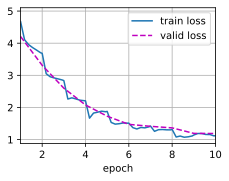

In [ ]:
# 训练和验证模型
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

# 自然语言预训练：BERT

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 加载语料库
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# 预训练BERT
net = d2l.BERTModel(
    len(vocab), num_hiddens=128, norm_shape=[128], ffn_num_input=128, 
    ffn_num_hiddens=256, num_heads=2, num_layers=2, dropout=0.2, key_size=128,
    query_size=128, value_size=128, hid_in_features=128, mlm_in_features=128, 
    nsp_in_features=128
)
device = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [ ]:
## 定义损失函数
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, 
                         valid_lens_x, pred_positions_X, mlm_weights_X, 
                         mlm_Y, nsp_y):
  _, mlm_Y_hat, nsp_Y_hat = net(
      tokens_X, segments_X, valid_lens_x.reshape(-1), pred_positions_X
  )
  mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)
  mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
  nsp_l = loss(nsp_Y_hat, nsp_y)
  l = mlm_l + nsp_l
  return mlm_l, nsp_l, l

In [ ]:
## 训练函数
def train_bert(train_iter, net, loss, vocab_size, device, num_steps):
  net = net.to(device[0])
  trainer = torch.optim.Adam(net.parameters(), lr=0.01)
  step, timer = 0, d2l.Timer()
  animator = d2l.Animator(
      xlabel='step', ylabel='loss', xlim=[1, num_steps], legend=['mlm', 'nsp']
  )
  metric = d2l.Accumulator(4)
  num_steps_reached = False
  while step < num_steps and not num_steps_reached:
    for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
      tokens_X = tokens_X.to(device[0])
      segments_X = segments_X.to(device[0])
      valid_lens_x = valid_lens_x.to(device[0])
      pred_positions_X = pred_positions_X.to(device[0])
      mlm_weights_X = mlm_weights_X.to(device[0])
      mlm_Y, nsp_y = mlm_Y.to(device[0]), nsp_y.to(device[0])
      trainer.zero_grad()
      timer.start()
      mlm_l, nsp_l, l = _get_batch_loss_bert(
          net, loss, vocab_size, tokens_X, segments_X, valid_lens_x, 
          pred_positions_X, mlm_weights_X, mlm_Y, nsp_y
      )
      l.backward()
      trainer.step()
      metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
      timer.stop()
      animator.add(step + 1, (metric[0] / metric[3], metric[1] / metric[3]))
      step += 1
      if step == num_steps:
        num_steps_reached = True
        break

  print(f'MLM loss {metric[0] / metric[3]:.3f}, NSP loss {metric[1] / metric[3]:.3f}')
  print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on {str(device)}')

MLM loss 5.389, NSP loss 0.765
2271.6 sentence pairs/sec on [device(type='cuda', index=0)]


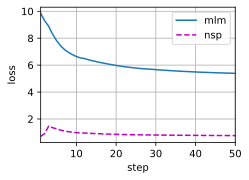

In [ ]:
train_bert(train_iter, net, loss, len(vocab), device, 50)

In [ ]:
# 用BERT表示文本
def get_bert_encoding(net, tokens_a, tokens_b=None):
  tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
  token_ids = torch.tensor(vocab[tokens], device=device[0]).unsqueeze(0)
  segments = torch.tensor(segments, device=device[0]).unsqueeze(0)
  valid_len = torch.tensor(len(tokens), device=device[0]).unsqueeze(0)
  encoded_X, _, _ = net(token_ids, segments, valid_len)
  return encoded_X

In [ ]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([0.0229, 0.8857, 1.5321], device='cuda:0', grad_fn=<SliceBackward0>))

In [ ]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([0.1701, 0.8689, 1.6298], device='cuda:0', grad_fn=<SliceBackward0>))

# 自然语言处理：应用

## 情感分析：使用递归神经网络

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 加载和预处理数据集
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [ ]:
# 使用RNN表示单个文本
class BiRNN(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
    super(BiRNN, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
    self.decoder = nn.Linear(4 * num_hiddens, 2)
  
  def forward(self, inputs):
    embeddings = self.embedding(inputs.T)
    self.encoder.flatten_parameters()
    outputs, _ = self.encoder(embeddings)
    encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
    outs = self.decoder(encoding)
    return outs

embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
  if type(m) == nn.LSTM:
    for param in m._flat_weights_names:
      if "weight" in param:
        nn.init.xavier_uniform_(m._parameters[param])

net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [ ]:
# 加载预训练的词向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]

In [ ]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.278, train acc 0.882, test acc 0.855
995.7 examples/sec on [device(type='cuda', index=0)]


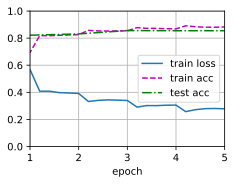

In [ ]:
# 训练和评估模型
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
# 预测文本情感
def predict_sentiment(net, vocab, sequence):
  sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
  label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
  return 'positive' if label == 1 else 'negative'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so sad')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## 情感分析：使用CNN

In [ ]:
# 定义模型
class TextCNN(nn.Module):
  def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, **kwargs):
    super(TextCNN, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.constant_embedding = nn.Embedding(vocab_size, embed_size)
    self.dropout = nn.Dropout(0.5)
    self.decoder = nn.Linear(sum(num_channels), 2)
    self.pool = nn.AdaptiveAvgPool1d(1)
    self.relu = nn.ReLU()
    self.convs = nn.ModuleList()
    for c, k in zip(num_channels, kernel_sizes):
      self.convs.append(nn.Conv1d(2 * embed_size, c, k))
    
  def forward(self, inputs):
    embeddings = torch.cat((self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
    embeddings = embeddings.permute(0, 2, 1)
    encoding = torch.cat(
        [torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1) for conv in self.convs], dim=1
    )
    outputs = self.decoder(self.dropout(encoding))
    return outputs

In [ ]:
embed_size, kernel_sizes, num_channels = 100, [3, 4, 5], [100, 100, 100]
net = TextCNN(len(vocab), embed_size, kernel_sizes, num_channels)

def init_weights(m):
  if type(m) in (nn.Linear, nn.Conv1d):
    nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

TextCNN(
  (embedding): Embedding(49346, 100)
  (constant_embedding): Embedding(49346, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

In [ ]:
# 加载预训练的词向量
# glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

loss 0.069, train acc 0.977, test acc 0.858
2545.3 examples/sec on [device(type='cuda', index=0)]


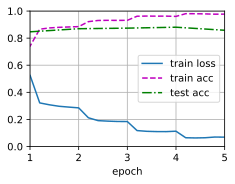

In [ ]:
# 训练和评估模型
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
predict_sentiment(net, vocab, 'this movie is so sad')

'negative'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## 自然语言推断：使用注意力

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
# 注意
def mlp(num_inputs, num_hiddens, flatten):
  net = []
  net.append(nn.Dropout(0.2))
  net.append(nn.Linear(num_inputs, num_hiddens))
  net.append(nn.ReLU())
  if flatten:
    net.append(nn.Flatten(start_dim=1))
  net.append(nn.Dropout(0.2))
  net.append(nn.Linear(num_hiddens, num_hiddens))
  net.append(nn.ReLU())
  if flatten:
    net.append(nn.Flatten(start_dim=1))
  
  return nn.Sequential(*net)

class Attend(nn.Module):
  def __init__(self, num_inputs, num_hiddens, **kwargs):
    super(Attend, self).__init__(**kwargs)
    self.f = mlp(num_inputs, num_hiddens, flatten=False)

  def forward(self, A, B):
    f_A = self.f(A)
    f_B = self.f(B)
    e = torch.bmm(f_A, f_B.permute(0, 2, 1))
    beta = torch.bmm(F.softmax(e, dim=-1), B)
    alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)

    return beta, alpha

In [ ]:
# 比较
class Compare(nn.Module):
  def __init__(self, num_inputs, num_hiddens, **kwargs):
    super(Compare, self).__init__(**kwargs)
    self.g = mlp(num_inputs, num_hiddens, flatten=False)
  
  def forward(self, A, B, beta, alpha):
    V_A = self.g(torch.cat([A, beta], dim=2))
    V_B = self.g(torch.cat([B, alpha], dim=2))

    return V_A, V_B

In [ ]:
# 聚合
class Aggregate(nn.Module):
  def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
    super(Aggregate, self).__init__(**kwargs)
    self.h = mlp(num_inputs, num_hiddens, flatten=True)
    self.linear = nn.Linear(num_hiddens, num_outputs)
  
  def forward(self, V_A, V_B):
    V_A = V_A.sum(dim=1)
    V_B = V_B.sum(dim=1)
    Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))

    return Y_hat

In [ ]:
# 整合代码
class DecomposableAttention(nn.Module):
  def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100, 
               num_inputs_compare=200, num_inputs_agg=400, **kwargs):
    super(DecomposableAttention, self).__init__(**kwargs)
    self.embedding = nn.Embedding(len(vocab), embed_size)
    self.attend = Attend(num_inputs_attend, num_hiddens)
    self.compare = Compare(num_inputs_compare, num_hiddens)
    self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)
  
  def forward(self, X):
    premises, hypotheses = X
    A = self.embedding(premises)
    B = self.embedding(hypotheses)
    beta, alpha = self.attend(A, B)
    V_A, V_B = self.compare(A, B, beta, alpha)
    Y_hat = self.aggregate(V_A, V_B)
    return Y_hat

In [ ]:
# 训练和评估模型
## 读取数据集
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
## 创建模型
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.2871, -0.5999,  0.4688,  ...,  0.3639, -0.8138, -0.2211],
        [ 0.9682,  0.0718,  0.1710,  ...,  0.1024,  1.3345, -0.4854],
        [ 0.1964,  0.0332,  0.1263,  ...,  0.1077,  0.0260,  0.8928]])

loss 0.499, train acc 0.804, test acc 0.825
15111.2 examples/sec on [device(type='cuda', index=0)]


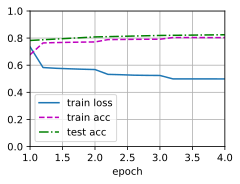

In [ ]:
## 训练和评估模型
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

In [ ]:
# 使用模型预测
def predict_snli(net, vocab, premise, hypothesis):
  net.eval()
  premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
  hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
  label = torch.argmax(net([premise.reshape((1, -1)), hypothesis.reshape((1, -1))]), dim=1)

  return 'entailment' if label == 0 else 'contradiction' if label == 1 else 'neutral'

In [ ]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

## 自然语言推断：微调BERT

In [5]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
# 加载bert
d2l.DATA_HUB['bert.small'] = (
    d2l.DATA_URL + 'bert.small.torch.zip',
    'c72329e68a732bef0452e4b96a1c341c8910f81f'
)

def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
  data_dir = d2l.download_extract(pretrained_model)
  # 定义空词表以加载预定义词表
  vocab = d2l.Vocab()
  vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
  vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}
  bert = d2l.BERTModel(
      len(vocab), num_hiddens, norm_shape=[256], ffn_num_input=256, 
      ffn_num_hiddens=ffn_num_hiddens, num_heads=4, num_layers=2, dropout=0.2,
      max_len=max_len, key_size=256, query_size=256, value_size=256, 
      hid_in_features=256, mlm_in_features=256, nsp_in_features=256
  )
  # 加载预训练BERT参数
  bert.load_state_dict(torch.load(os.path.join(data_dir, 'pretrained.params')))
  
  return bert, vocab


devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
     num_layers=2, dropout=0.1, max_len=512, devices=devices
)

In [7]:
# 微调BERT的数据集
class SNLIBERTDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, max_len, vocab=None):
    all_premise_hypothesis_tokens = [
      [p_tokens, h_tokens] for p_tokens, h_tokens in zip(
          *[d2l.tokenize([s.lower() for s in sentences]) for sentences in dataset[:2]])
    ]
    self.labels = torch.tensor(dataset[2])
    self.vocab = vocab
    self.max_len = max_len
    (
        self.all_token_ids, self.all_segments, self.valid_lens
    ) = self._preprocess(all_premise_hypothesis_tokens)
    print('read ' + str(len(self.all_token_ids)) + ' examples')
  
  def _mp_worker(self, premise_hypothesis_tokens):
    p_tokens, h_tokens = premise_hypothesis_tokens
    self._truncate_pair_of_tokens(p_tokens, h_tokens)
    tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
    token_ids = self.vocab[tokens] + [self.vocab['<pad>']] * (self.max_len - len(tokens))
    segments = segments + [0] * (self.max_len - len(segments))
    valid_len = len(tokens)

    return token_ids, segments, valid_len

  def _preprocess(self, all_premise_hypothesis_tokens):
    pool = multiprocessing.Pool(4)
    out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
    all_token_ids = [token_ids for token_ids, segments, valid_len in out]
    all_segments = [segments for token_ids, segments, valid_len in out]
    valid_lens = [valid_len for token_ids, segments, valid_len in out]

    return (
        torch.tensor(all_token_ids, dtype=torch.long),
        torch.tensor(all_segments,dtype=torch.long),
        torch.tensor(valid_lens)
    )
  
  def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
    while len(p_tokens) + len(h_tokens) > self.max_len - 3:
      if len(p_tokens) > len(h_tokens):
        p_tokens.pop()
      else:
        h_tokens.pop()
  
  def __getitem__(self, idx):
    return (
        self.all_token_ids[idx], self.all_segments[idx], self.valid_lens[idx],
        self.labels[idx]
    )
  
  def __len__(self):
    return len(self.all_token_ids)

In [13]:
batch_size, max_len, num_workers = 256, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, num_workers=num_workers)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
# 微调bert
class BERTClassifier(nn.Module):
  def __init__(self, bert):
    super(BERTClassifier, self).__init__()
    self.encoder = bert.encoder
    self.hidden = bert.hidden
    self.output = nn.Linear(256, 3)
  
  def forward(self, inputs):
    tokens_X, segments_X, valid_lens_x = inputs
    encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
    return self.output(self.hidden(encoded_X[:, 0, :]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ValueError: ignored

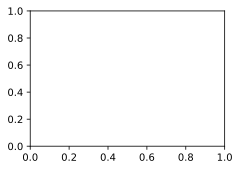

In [15]:
net = BERTClassifier(bert)
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [12]:
512 / 2

256.0